## Imports

In [14]:
%matplotlib inline
import time
import math
import theano
import theano.tensor as T
import lasagne
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

from skimage import measure
from data import generate as generate_training_data
from network import setup as setup_network
from minibatch import iterator as minibatch_iterator

## Some hyperparameters

In [2]:
box_size = 29
num_epochs = 15
learning_rate = 0.005
positive_sample_radius = 2
negative_sample_radius = 20

## Load data

In [3]:
t_samples, t_labels, _ = generate_training_data("train",
                                                box_size = box_size,
                                                positive_sample_radius = positive_sample_radius,
                                                negative_sample_radius = negative_sample_radius)

v_samples, v_labels, v_img = generate_training_data("validation",
                                                box_size = box_size,
                                                positive_sample_radius = positive_sample_radius,
                                                negative_sample_radius = negative_sample_radius)

### Normalize data

In [4]:
mu = t_samples.mean()
sigma = t_samples.std()

def normalize(data):
    return (data - mu)/sigma

t_samples = normalize(t_samples)
v_samples = normalize(v_samples)
v_img = normalize(v_img)

## Setup network

In [5]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
network = setup_network(input_var, box_size)

## Setup objective function

In [6]:
# Training
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=0.9)
train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

# Validation
val_prediction = lasagne.layers.get_output(network, deterministic=True)
val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var).mean()
val_acc = T.mean(T.eq(T.argmax(val_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [val_loss, val_acc], allow_input_downcast=True)

## Optimize parameters

In [7]:
for epoch in xrange(num_epochs):
    train_batches = 0
    val_batches = 0
    train_err = 0
    val_err = 0
    val_acc = 0
    start_time = time.time()

    for batch in minibatch_iterator(t_samples, t_labels, batchsize = 100, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    for batch in minibatch_iterator(v_samples, v_labels, batchsize = 100, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 15 took 10.970s
  training loss:	0.814728
  validation loss:	0.667830
  validation accuracy:	50.16 %
Epoch 2 of 15 took 11.339s
  training loss:	0.702776
  validation loss:	0.637797
  validation accuracy:	55.63 %
Epoch 3 of 15 took 12.002s
  training loss:	0.634815
  validation loss:	0.480465
  validation accuracy:	85.11 %
Epoch 4 of 15 took 11.687s
  training loss:	0.461669
  validation loss:	0.269768
  validation accuracy:	89.37 %
Epoch 5 of 15 took 12.205s
  training loss:	0.343270
  validation loss:	0.186295
  validation accuracy:	92.68 %
Epoch 6 of 15 took 11.897s
  training loss:	0.263369
  validation loss:	0.159776
  validation accuracy:	94.11 %
Epoch 7 of 15 took 11.099s
  training loss:	0.229890
  validation loss:	0.145556
  validation accuracy:	94.79 %
Epoch 8 of 15 took 11.557s
  training loss:	0.209988
  validation loss:	0.136941
  validation accuracy:	95.26 %
Epoch 9 of 15 took 11.466s
  training loss:	0.207066
  validation loss:	0.132370
  validation accuracy:	

## Sliding window

In [8]:
eval_fn = theano.function([input_var], val_prediction)
output = np.zeros((v_img.shape[0], v_img.shape[1], 2))

margin = int(math.floor(box_size / 2))
for x in xrange(margin, int(v_img.shape[0] - margin)):
    for y in xrange(margin, int(v_img.shape[1]-margin)):
        patch = v_img[x-margin:x+margin+1, y-margin:y+margin+1]
        patch = patch.reshape(1,1, box_size, box_size)
        output[x,y,:] = eval_fn(patch)

### Show segmentation

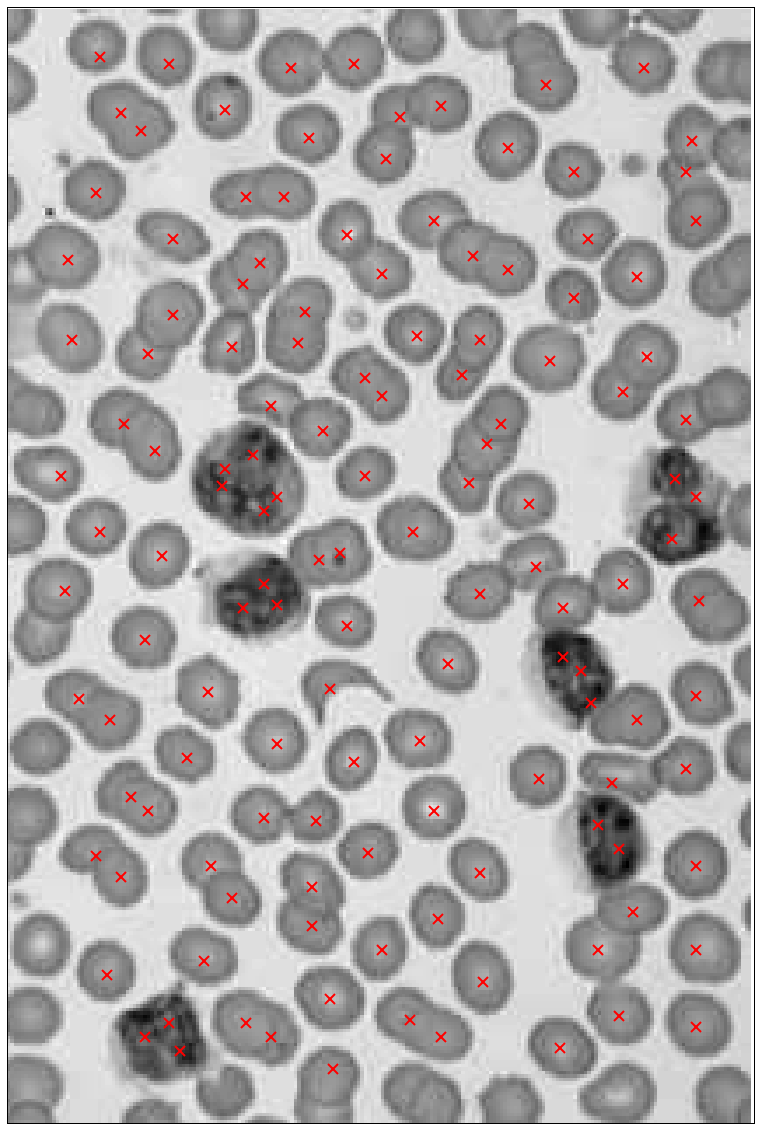

In [43]:
fig, ax = plt.subplots()
ax.imshow(v_img, interpolation='nearest', cmap=plt.cm.gray)

seg = output[:,:,0]>0.5
heatmap = filters.gaussian_filter(output[:,:,0], 1) 

#contours = measure.find_contours(seg, 0.01)
#for n, contour in enumerate(contours):
#    ax.plot(contour[:, 1], contour[:, 0], '-r', linewidth=2)

xy = np.where(np.multiply(seg, heatmap == filters.maximum_filter(heatmap, 3)))

plt.plot(xy[1], xy[0], 'rx', markersize=10, mew=2)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.rcParams['figure.figsize'] = 20,20